# Check Geomedian from collection 3

In [1]:
%matplotlib inline
import datacube
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import glob, os
import xarray as xr
import numpy as np

In [3]:
import pandas as pd
import geopandas as gpd

In [4]:
from shapely import geometry

In [5]:
def tile_id_to_shape(tile_id):
    tile_x = float(tile_id.split('_')[1])
    tile_y = float(tile_id.split('_')[3])
    minx, maxx = tile_x*6000,tile_x*6000+12000
    maxy, miny = tile_y*6000,tile_y*6000-12000
    return geometry.box(minx, miny, maxx, maxy)

In [ ]:
# compare wofs output

outcsv = 'wofs_diff_stats.csv'
diff = pd.read_csv(outcsv)
diff=diff[diff[' overlap']>=1.]
shapes = diff.tile_id.apply(tile_id_to_shape)
diff_shapes = gpd.GeoDataFrame(diff)
diff_shapes['geometry'] = shapes

In [ ]:
f, axes = plt.subplots(2, 3, figsize=(14,7))
axes = axes.ravel()
for iband, band in enumerate(['water_c3', 'water_c2', 'waterfrac_c3', 'waterfrac_c2']):
    diff_shapes[band] = np.abs(diff_shapes[band])
    diff_shapes.plot(column=band, cmap = 'viridis', ax = axes[iband],vmin=0, vmax=50)
    axes[iband].set_title(band)

In [ ]:
diff_shapes

In [360]:
#check output file

outcsv = 'diff_stats_20190907.csv'


In [412]:
diff = pd.read_csv(outcsv)

In [414]:
diff=diff[diff['overlap']>=1.]

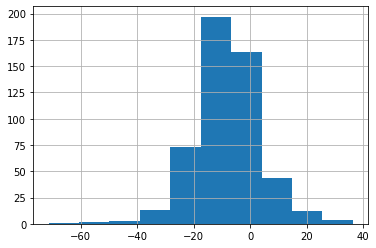

In [415]:
diff.blue_mean.hist()

        tile_id  blue_mean  blue_std  blue_abs90
103  x_12_y_-70      24.49     81.40       93.05
159  x_22_y_-76      25.84     25.05         NaN
237  x_34_y_-22      21.94     65.20         NaN
349  x_20_y_-76      36.36     34.70         NaN
446  x_28_y_-30      33.49     55.59      109.45
493  x_26_y_-64      27.92     28.74         NaN
        tile_id  green_mean  green_std  green_abs90
103  x_12_y_-70       23.56      78.59        86.18
152  x_22_y_-20       22.49      43.26        76.68
237  x_34_y_-22       37.25      64.60          NaN
302  x_32_y_-32       21.47      39.29        72.66
446  x_28_y_-30       34.27      52.00       104.70
548  x_36_y_-22       21.31      49.79        85.14
         tile_id  red_mean  red_std  red_abs90
40   x_-26_y_-56     21.66   104.90     162.52
103   x_12_y_-70     25.40    80.02      87.66
152   x_22_y_-20     20.08    43.31      74.60
237   x_34_y_-22     36.71    66.29        NaN
446   x_28_y_-30     32.87    53.65     105.62
628   x_16_

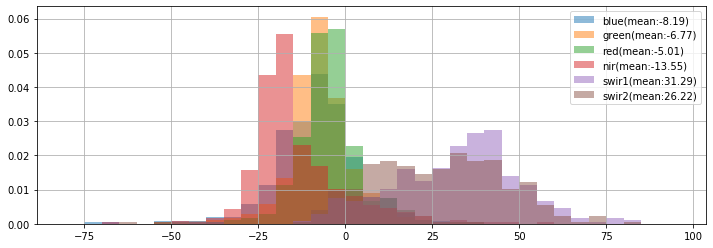

In [389]:
plt.figure(figsize=(12,4))
out={}
for band in ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']:
    #print(band, diff['%s_mean'%band].max(),diff['%s_std'%band].max(),diff['%s_abs90'%band].max())
    out[band]=diff[diff['%s_mean'%band]>np.nanpercentile(diff['%s_mean'%band],99)]
    print(out[band][['tile_id','%s_mean'%band,'%s_std'%band, '%s_abs90'%band]])
    
    diff['%s_mean'%band].hist(alpha=0.5, label=band+'(mean:%.2f)'%diff['%s_mean'%band].mean(), bins=np.arange(-80,100,5), density=True)

plt.legend()

In [400]:
shapes = diff.tile_id.apply(tile_id_to_shape)

In [418]:
diff_shapes = gpd.GeoDataFrame(diff)
diff_shapes['geometry'] = shapes

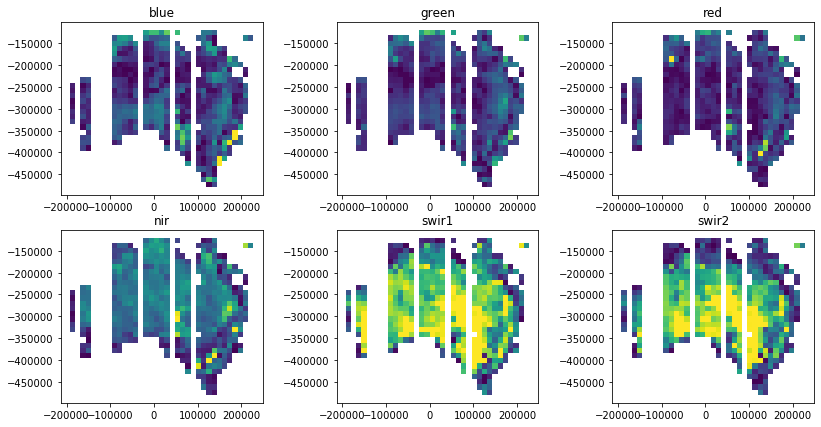

In [435]:
f, axes = plt.subplots(2, 3, figsize=(14,7))
axes = axes.ravel()
for iband, band in enumerate(['blue', 'green', 'red', 'nir', 'swir1', 'swir2']):
    diff_shapes['%s_mean_abs'%band] = np.abs(diff_shapes['%s_mean'%band])
    diff_shapes.plot(column='%s_mean_abs'%band, cmap = 'viridis', ax = axes[iband],vmin=0, vmax=50)
    axes[iband].set_title(band)

## load tile and compare

In [369]:
tile_id = 'x_34_y_-22'
tile_x = '_'.join(tile_id.split('_')[:2])
tile_y = '_'.join(tile_id.split('_')[2:])

In [397]:
minx, maxx = float(tile_x.split('_')[1])*6000,float(tile_x.split('_')[1])*6000+12000
maxy, miny = float(tile_y.split('_')[1])*6000,float(tile_y.split('_')[1])*6000-12000

## compare to collection 2

In [140]:
prod_dc = datacube.Datacube()

In [141]:
#dss = prod_dc.find_datasets(product='ls8_nbart_geomedian_annual', time=('2015-01-01','2015-01-01'))

In [375]:
c3_path = glob.glob('/g/data/u46/users/ea6141/stats-tests/gm_c3/LS_GM/%s/%s'%(tile_x,tile_y))[0]

c3s =[]
c2s =[]
for iband, band in enumerate(['blue', 'green', 'red', 'nir', 'swir1', 'swir2']):
    try:
        c3_file = glob.glob('%s/2015/*_%s.tif'%(c3_path,band))[0]
    except:
        c3_file = glob.glob('%s/2015/*_%s_%s.tif'%(c3_path,band[:-1], band[-1]))[0]
    c3 = xr.open_rasterio(c3_file).to_dataset(dim='band').rename({1:band})
    c2 = prod_dc.load(product='ls8_nbart_geomedian_annual', time=('2015-01-01','2015-02-01'),
                        x=(c3.x.min().values-30,c3.x.max().values+30),
                        y=(c3.y.min().values-30,c3.y.max().values+30),
                        crs="EPSG:3577",
                        measurements=[band],
                ).interp_like(c3, method='linear')
    c3s.append(c3)
    c2s.append(c2)

In [390]:
c3_multi=xr.merge(c3s)
c2_multi=xr.merge(c2s)

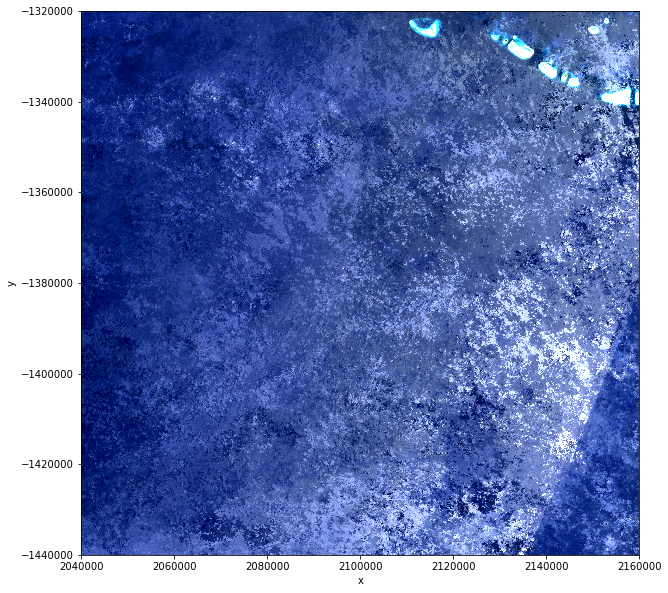

In [391]:
c3_multi[['red','green','blue']].to_array().plot.imshow(figsize=(10,10),robust=True)

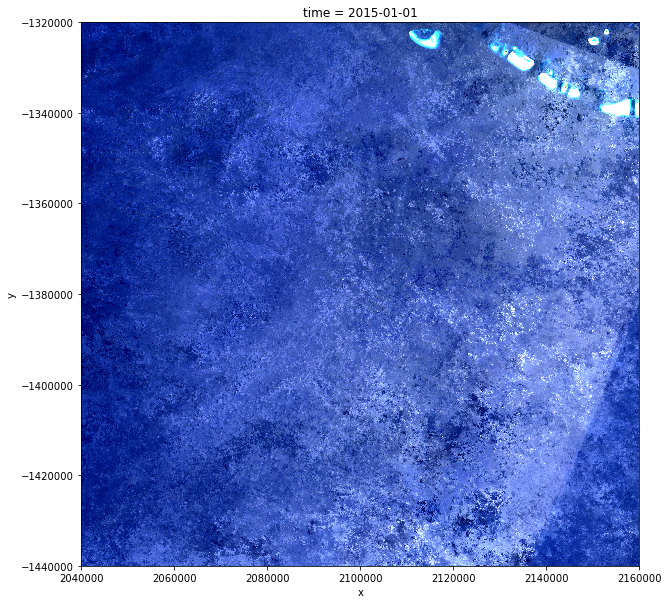

In [392]:
c2_multi[['red','green','blue']].squeeze().to_array().plot.imshow(figsize=(10,10),robust=True)